<a href="https://colab.research.google.com/github/reza-pishva/1-SchoolProject-Php-Laravel/blob/main/rnn7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import yfinance as yf
from darts import TimeSeries
from darts.models import TCNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import pandas as pd
from datetime import datetime
import numpy as np
from darts.metrics import mae,mape

In [115]:
# Fetch MSFT stock data
msft = yf.Ticker('MSFT')
data = msft.history(start='2023-01-01', end='2024-02-01')
data.to_csv('msft_data.csv')
df2 = pd.read_csv('msft_data.csv')

In [116]:
df2

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-01-03 00:00:00-05:00,239.633914,242.266060,234.034430,236.183533,25740000,0.0,0.0
1,2023-01-04 00:00:00-05:00,228.987007,229.568639,222.756612,225.852097,50623400,0.0,0.0
2,2023-01-05 00:00:00-05:00,223.979046,224.324090,218.616165,219.158371,39585600,0.0,0.0
3,2023-01-06 00:00:00-05:00,219.838579,222.559446,216.240331,221.741211,43613600,0.0,0.0
4,2023-01-09 00:00:00-05:00,223.239662,227.961764,223.200236,223.900162,27369800,0.0,0.0
...,...,...,...,...,...,...,...,...
266,2024-01-25 00:00:00-05:00,402.122283,404.797663,400.342004,402.669281,21021200,0.0,0.0
267,2024-01-26 00:00:00-05:00,402.172016,403.962250,400.242559,401.734406,17803300,0.0,0.0
268,2024-01-29 00:00:00-05:00,403.852811,407.751516,402.132203,407.492920,24510200,0.0,0.0
269,2024-01-30 00:00:00-05:00,410.019144,410.804828,404.240727,406.369080,33477600,0.0,0.0


In [117]:
# Preprocess the data
df2['Date'] = pd.to_datetime(df2['Date'], utc=True)
df2['Date'] = df2['Date'].dt.tz_localize(None)
df2['Date'] = df2['Date'].dt.date
df2['Date'] = pd.to_datetime(df2['Date'])

<Axes: xlabel='Date'>

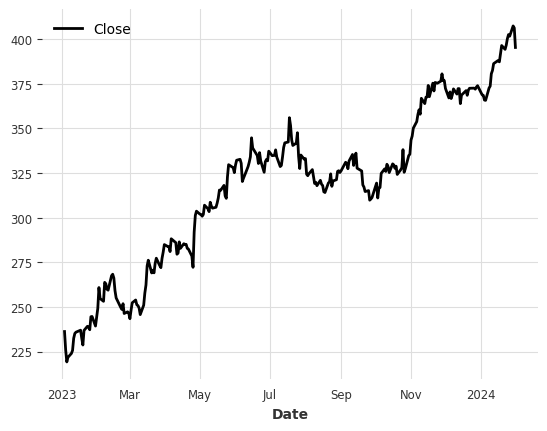

In [118]:
# Create a TimeSeries object and fill missing values
series = fill_missing_values(TimeSeries.from_dataframe(df2, time_col='Date', value_cols='Close', freq="D"), "auto", fill_missing_dates=True)
series.plot()

In [119]:
# Initialize the Darts scaler
scaler = Scaler()
# Fit and transform the data
scaled_data = scaler.fit_transform(series)

In [120]:
# Split the dataset into training and test sets
train_ts, val_ts = scaled_data.split_after(pd.Timestamp('2024-01-01'))

In [121]:
# Initialize the TCN model
tcn_model = TCNModel(
    input_chunk_length=30,
    output_chunk_length=15,
    kernel_size=3,
    num_filters=3,
    dropout=0.1,
    dilation_base=2,
    n_epochs=20,
    likelihood=GaussianLikelihood(),
)

In [122]:
# Fit the model on the training data
tcn_model.fit(train_ts)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 226    | train
-------------------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.1, input_chunk_length=30, output_chunk_length=15, n_epochs=20, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0))

In [123]:
# Make predictions on the test dataset
prediction = tcn_model.predict(len(val_ts))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Date'>

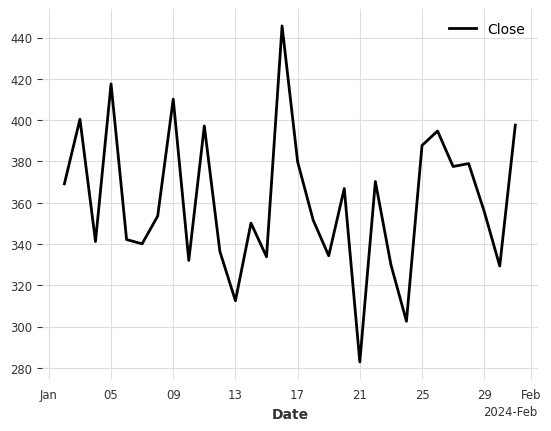

In [124]:
# Inverse transform the predictions (if needed)
inverted_prediction = scaler.inverse_transform(prediction)
inverted_prediction.plot()

In [125]:
mae(val_ts,inverted_prediction)

359.8409797492215

In [126]:
historical_forcast_meantemp = tcn_model.historical_forecasts(
    series = scaled_data,
    num_samples = 50,
    start = 0.9,
    stride = 30,
    forecast_horizon = 10,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 226    | train
-------------------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [127]:
datetime_covariate = datetime_attribute_timeseries(series, attribute="month", one_hot=False)
datetime_covariate.stack(datetime_attribute_timeseries(series, attribute="year", one_hot=False))

<TimeSeries (DataArray) (Date: 394, component: 2, sample: 1)> Size: 6kB
array([[[0.000e+00],
        [2.023e+03]],

       [[0.000e+00],
        [2.023e+03]],

       [[0.000e+00],
        [2.023e+03]],

       [[0.000e+00],
        [2.023e+03]],

       [[0.000e+00],
        [2.023e+03]],

       [[0.000e+00],
        [2.023e+03]],

       [[0.000e+00],
        [2.023e+03]],
...
       [[0.000e+00],
        [2.024e+03]],

       [[0.000e+00],
        [2.024e+03]],

       [[0.000e+00],
        [2.024e+03]],

       [[0.000e+00],
        [2.024e+03]],

       [[0.000e+00],
        [2.024e+03]],

       [[0.000e+00],
        [2.024e+03]],

       [[0.000e+00],
        [2.024e+03]]])
Coordinates:
  * Date       (Date) datetime64[ns] 3kB 2023-01-03 2023-01-04 ... 2024-01-31
  * component  (component) object 16B 'month' 'year'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [128]:
# Split the dataset into training and test sets
train_ts, val_ts = datetime_covariate.split_after(0.8)

In [129]:
# Initialize the TCN model
tcn_model = TCNModel(
    input_chunk_length=30,
    output_chunk_length=15,
    kernel_size=3,
    num_filters=3,
    dropout=0.1,
    dilation_base=2,
    n_epochs=20,
    likelihood=GaussianLikelihood(),
)

In [130]:
# Fit the model on the training data
tcn_model.fit(train_ts)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 226    | train
-------------------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.1, input_chunk_length=30, output_chunk_length=15, n_epochs=20, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0))

In [131]:
# Make predictions on the test dataset
prediction = tcn_model.predict(100, num_samples=100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Date'>

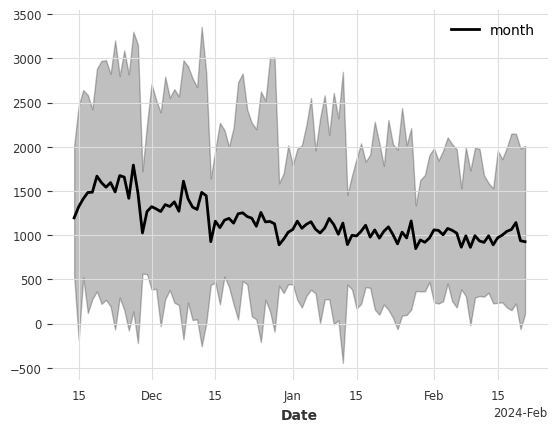

In [132]:
# Inverse transform the predictions (if needed)
inverted_prediction = scaler.inverse_transform(prediction)
inverted_prediction.plot()

In [133]:
mae(val_ts,inverted_prediction)

1198.4766287299162

In [134]:
# Historical forecasts
historical_forecast_meantemp = tcn_model.historical_forecasts(
    series=datetime_covariate,
    num_samples=50,
    start=0.9,
    stride=30,
    forecast_horizon=10,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 226    | train
-------------------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [135]:
# Make predictions on the test dataset
prediction = tcn_model.predict(100, num_samples=100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Date'>

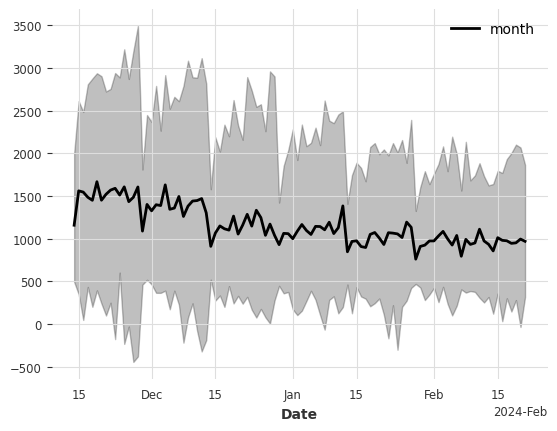

In [136]:
# Inverse transform the predictions (if needed)
inverted_prediction = scaler.inverse_transform(prediction)
inverted_prediction.plot()

In [137]:
# Calculate Mean Absolute Error
mae_val = mae(val_ts, inverted_prediction)
print(f"Mean Absolute Error on validation set: {mae_val:.2f}")

Mean Absolute Error on validation set: 1207.07


In [138]:
# Initialize the Darts scaler
scaler = Scaler()
# Fit and transform the data
scaled_data = scaler.fit_transform(series)

In [139]:
# Split the dataset into training and test sets
train_ts, val_ts = scaled_data.split_after(pd.Timestamp('2024-01-01'))

In [140]:
# Define a list of hyperparameters to explore
output_chunk_lengths = [5, 10, 15]
input_chunk_lengths = [30, 40, 50]

In [141]:
best_mae = float('inf')
best_mape = float('inf')
best_model = None

In [147]:
# Iterate over hyperparameter combinations
for output_chunk_length in output_chunk_lengths:
      for input_chunk_length in input_chunk_lengths:
        tcn_model = TCNModel(
        input_chunk_length=30,
        output_chunk_length=15,
        kernel_size=3,
        num_filters=3,
        dropout=0.1,
        dilation_base=2,
        n_epochs=20,
        likelihood=GaussianLikelihood())
        tcn_model.fit(train_ts)
        prediction = tcn_model.predict(len(val_ts))
        inverted_prediction = scaler.inverse_transform(prediction)

        # Calculate MAE and MAPE
        mae = np.abs(val_ts.univariate_values() - inverted_prediction.univariate_values()).mean()
        mape = (np.abs(val_ts.univariate_values() - inverted_prediction.univariate_values()) / val_ts.univariate_values()).mean() * 100

        # Update best model if necessary
        if mae < best_mae:
            best_mae = mae
            best_mape = mape
            best_model = tcn_model

print(f"Best MAE: {best_mae:.4f}")
print(f"Best MAPE: {best_mape:.2f}%")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 226    | train
-------------------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 226    | train
-------------------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 226    | train
-------------------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 226    | train
-------------------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 226    | train
-------------------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 226    | train
-------------------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 226    | train
-------------------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 226    | train
-------------------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 226    | train
-------------------------------------------------------------
226       Trainable params
0         Non-trainable params
226       Total params
0.001     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Best MAE: 316.7479
Best MAPE: 35587.68%
